In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from celluloid import Camera
import math as mt
from functools import reduce
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor, PrevPublicPredictor
from IPython.display import clear_output, Markdown, display

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

In [4]:
# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)
m.head()

,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트1-104-303,아파트1-104-404,아파트1-104-408,아파트1-104-503,아파트1-104-507,아파트1-104-606,아파트1-104-705,아파트1-104-708,아파트1-104-902,아파트1-104-905
month,,,,,,,,,,,,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350,...,10,111,39,151,181,180,290,184,176,148
2,251,481,177,218,397,297,339,197,348,288,...,77,107,30,114,151,151,263,177,158,127
3,255,424,203,222,378,303,349,202,357,368,...,77,120,28,116,163,157,281,182,171,127
4,252,355,180,230,368,278,298,188,346,365,...,76,64,58,109,151,148,257,175,140,121
5,230,357,258,203,414,270,418,156,320,265,...,150,63,75,137,115,13,84,149,36,117


# 데이터

In [51]:
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)
month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 20
households_kWh = month_df['usage (kWh)'].sum()
APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))

# 공용부 사용량이 APT 상에서 30%를 차지하도록 설정
public_kWh = APT - households_kWh

# 예측 시뮬레이션
pp = PublicPredictor(
    APT=APT,
    month_df=month_df,
    month=_month
)

calc = crs.models.ManagementOffice(
    APT = APT,
    month = _month,
    households = month_df,
    contract="단일계약"
)
fee = calc.fee

month_df.head(10)

,name,usage (kWh)
0,아파트1-101-1002,253
1,아파트1-101-104,689
2,아파트1-101-1102,183
3,아파트1-101-1202,239
4,아파트1-101-1302,455
5,아파트1-101-1401,343
6,아파트1-101-1403,380
7,아파트1-101-1502,219
8,아파트1-101-1504,389
9,아파트1-101-1602,350


In [52]:
basic_col_burden = list()
basic_col = list()
now_apt_step = 0
APT_mean = round(APT / len(month_df))

for step,_ in enumerate(fee):
    if APT_mean < _[1]:
        now_apt_step = step
        break
        
for usage in month_df['usage (kWh)']:    
    _basic = 0
    for _ in fee:
        if usage < _[1]:
            _basic = _[2]
            basic_col_burden.append(fee[now_apt_step][2] / _basic)
            basic_col.append(_basic)
            break

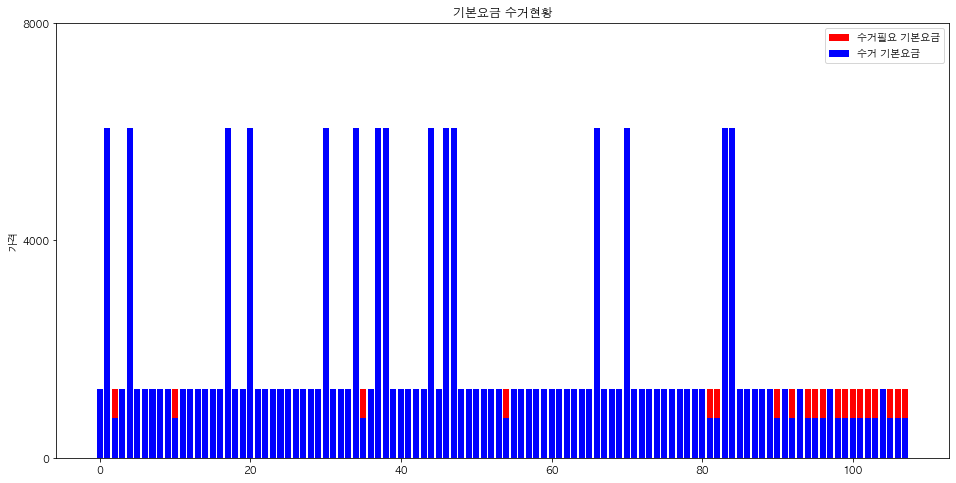

In [53]:
plt.figure(figsize=(16,8))

plt.bar(range(len(month_df)),fee[now_apt_step][2], label='수거필요 기본요금', color='r')
plt.bar(range(len(month_df)),basic_col, label='수거 기본요금', color='b')

plt.title("기본요금 수거현황")
plt.legend()
plt.yticks([0, 4000, 8000])
plt.ylabel("가격")

plt.show()

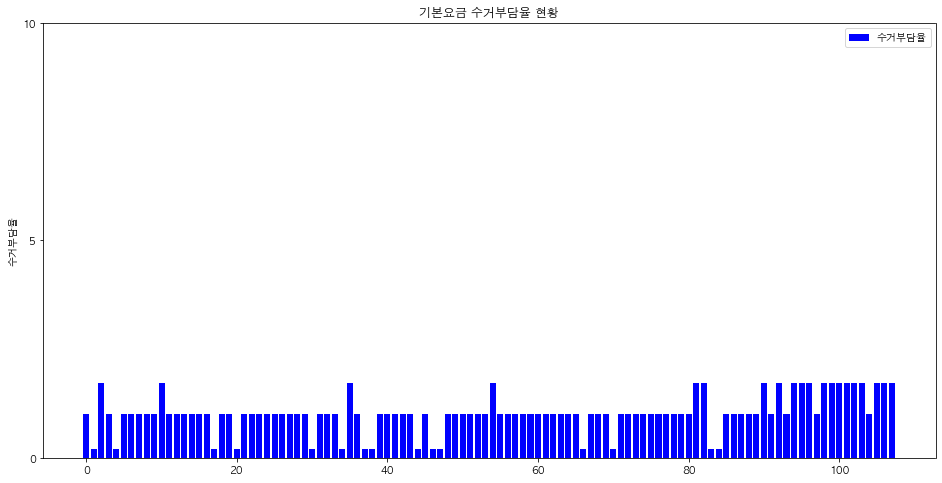

In [54]:
plt.figure(figsize=(16,8))

plt.bar(range(len(month_df)),basic_col_burden, label='수거부담율', color='b')
plt.title("기본요금 수거부담율 현황")
plt.legend()
plt.yticks([0, 5, 10])
plt.ylabel("수거부담율")

plt.show()